# LIBRARY

In [1]:
import pandas as pd
import numpy as np
import re, joblib
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split, cross_validate 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# DATASET

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,label,tweet
0,anger,soal jalan jatibaru polisi tidak bisa gertak g...
1,anger,sesama cewek lho kayaknya harusnya bisa leb...
2,happy,kepingin gudeg mbarek bu hj amad foto dari go...
3,anger,jln jatibaru bagian dari wilayah tanah abang p...
4,happy,sharing pengalaman saja kemarin jam batalin...


# TWEET DAN LABEL DATASET

In [3]:
text = df['tweet']
Y = df['label']

# VEKTORISASI

## 1. TF-IDF

In [4]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(text)

## 2. BIGRAM

In [5]:
bigram = CountVectorizer(ngram_range=(2,2))
X_bigram = bigram.fit_transform(text)

# OVERSAMPLING

## 1. SMOTE TF-IDF

In [6]:
counter = Counter(Y)
print('Sebelum SMOTE :',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE(random_state=0)
X_tfidf_sm, Y_tfidf_sm = smt.fit_resample(X_tfidf, Y)

counter = Counter(Y_tfidf_sm)
print('Setelah SMOTE :',counter)

Sebelum SMOTE : Counter({'anger': 1101, 'happy': 1017, 'sadness': 997, 'fear': 649, 'love': 637})
Setelah SMOTE : Counter({'anger': 1101, 'happy': 1101, 'sadness': 1101, 'love': 1101, 'fear': 1101})


## 2. SMOTE BIGRAM

In [7]:
counter = Counter(Y)
print('Sebelum SMOTE :',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE(random_state=0)
X_bigram_sm, Y_bigram_sm = smt.fit_resample(X_bigram, Y)

counter = Counter(Y_bigram_sm)
print('Sebelum SMOTE :',counter)

Sebelum SMOTE : Counter({'anger': 1101, 'happy': 1017, 'sadness': 997, 'fear': 649, 'love': 637})
Sebelum SMOTE : Counter({'anger': 1101, 'happy': 1101, 'sadness': 1101, 'love': 1101, 'fear': 1101})


# PEMBAGIAN DATASET

## 1. TRAINING DAN TESTING (SMOTE + TF-IDF)

In [8]:
X_train_tfidf, X_test_tfidf, Y_train_tfidf, Y_test_tfidf = train_test_split(X_tfidf_sm, Y_tfidf_sm, test_size=0.1, random_state=0, stratify = Y_tfidf_sm)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(Y_train_tfidf.shape)
print(Y_test_tfidf.shape)

(4954, 18037)
(551, 18037)
(4954,)
(551,)


## 2. TRAINING DAN TESTING (SMOTE + BIGRAM)

In [9]:
X_train_bigram, X_test_bigram, Y_train_bigram, Y_test_bigram = train_test_split(X_bigram_sm, Y_bigram_sm, test_size=0.1, random_state=0, stratify = Y_bigram_sm)
print(X_train_bigram.shape)
print(X_test_bigram.shape)
print(Y_train_bigram.shape)
print(Y_test_bigram.shape)

(4954, 86121)
(551, 86121)
(4954,)
(551,)


# PEMODELAN TIAP SKENARIO
### Algoritma : KNN dan SVM Kernel RBF

## 1. KNN (SMOTE+GRID+TFIDF) {n_neighbors = 1}

In [10]:
model1 = KNeighborsClassifier(n_neighbors = 1)

In [11]:
# Evaluasi training tiap skenario dengan 10-Fold CV
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
score1 = cross_validate(model1, X_train_tfidf, Y_train_tfidf, cv=10, scoring=scoring)
print("Accuracy training adalah %0.4f"% score1['test_accuracy'].mean())
print("Precision training adalah %0.4f"% score1['test_precision_macro'].mean())
print("Recall training adalah %0.4f"% score1['test_recall_macro'].mean())
print("F1-score training adalah %0.4f"% score1['test_f1_macro'].mean())

Accuracy training adalah 0.5373
Precision training adalah 0.6136
Recall training adalah 0.5373
F1-score training adalah 0.4790


In [12]:
# Evaluasi testing tiap skenario dengan representasi confusion matrix
clf1 = model1.fit(X_train_tfidf, Y_train_tfidf)
predicted1 = clf1.predict(X_test_tfidf) # prediksi oleh model
print("Accuracy testing adalah %0.4f" % accuracy_score(Y_test_tfidf, predicted1))
print("Precision testing adalah %0.4f" % precision_score(Y_test_tfidf, predicted1, average='macro'))
print("Recall testing adalah %0.4f" % recall_score(Y_test_tfidf, predicted1, average='macro'))
print("F1-score testing adalah %0.4f" % f1_score(Y_test_tfidf, predicted1, average='macro'))
print(confusion_matrix(Y_test_tfidf, predicted1))

Accuracy testing adalah 0.5408
Precision testing adalah 0.6492
Recall testing adalah 0.5412
F1-score testing adalah 0.4861
[[ 11  44   9  36  10]
 [  0 100   1   7   2]
 [  0  31  47  27   5]
 [  0   2   2 103   3]
 [  1  25   8  40  37]]


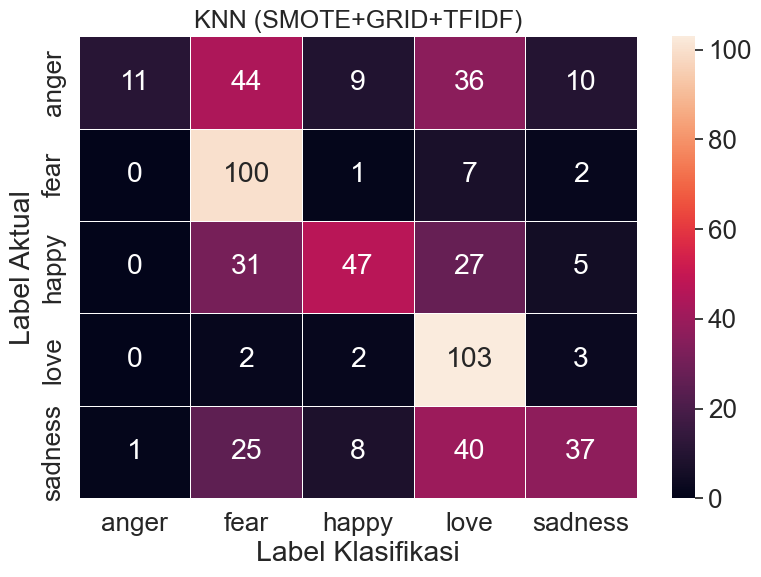

In [28]:
# menampilkan confusion matrix
temp = Y_test_tfidf.value_counts()
df1 = pd.DataFrame({'label': sorted(temp.index),
                   'values': temp.values
                  })
f, ax = plt.subplots(figsize=(9,6))
sns.set(font_scale=1.7) # Adjust to fit
sns.heatmap(confusion_matrix(Y_test_tfidf, predicted1), annot=True, fmt="g", ax=ax, linewidths=.5)
plt.title('KNN (SMOTE+GRID+TFIDF)', fontsize=18)
plt.xlabel("Label Klasifikasi")
plt.ylabel("Label Aktual")
ax.xaxis.set_ticklabels(df1['label'])
ax.yaxis.set_ticklabels(df1['label'])
plt.show()

## 2. SVM-RBF (SMOTE+GRID+TFIDF) {C = 10, gamma = 0.1}

In [14]:
model2 = SVC(kernel='rbf', probability=True, C = 10, gamma = 0.1)

In [15]:
# Evaluasi training tiap skenario dengan 10-Fold CV
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
score2 = cross_validate(model2, X_train_tfidf, Y_train_tfidf, cv=10, scoring=scoring)
print("Accuracy training adalah %0.4f"% score2['test_accuracy'].mean())
print("Precision training adalah %0.4f"% score2['test_precision_macro'].mean())
print("Recall training adalah %0.4f"% score2['test_recall_macro'].mean())
print("F1-score training adalah %0.4f"% score2['test_f1_macro'].mean())

Accuracy training adalah 0.7683
Precision training adalah 0.7742
Recall training adalah 0.7682
F1-score training adalah 0.7699


In [16]:
# Evaluasi testing tiap skenario dengan representasi confusion matrix
clf2 = model2.fit(X_train_tfidf, Y_train_tfidf)
predicted2 = clf2.predict(X_test_tfidf) # prediksi oleh model
print("Accuracy testing adalah %0.4f" % accuracy_score(Y_test_tfidf, predicted2))
print("Precision testing adalah %0.4f" % precision_score(Y_test_tfidf, predicted2, average='macro'))
print("Recall testing adalah %0.4f" % recall_score(Y_test_tfidf, predicted2, average='macro'))
print("F1-score testing adalah %0.4f" % f1_score(Y_test_tfidf, predicted2, average='macro'))
print(confusion_matrix(Y_test_tfidf, predicted2))

Accuracy testing adalah 0.7604
Precision testing adalah 0.7637
Recall testing adalah 0.7607
F1-score testing adalah 0.7619
[[ 76   3  15   2  14]
 [  9  96   4   1   0]
 [ 11   2  76   2  19]
 [  2   2   2 100   4]
 [ 21   3  13   3  71]]


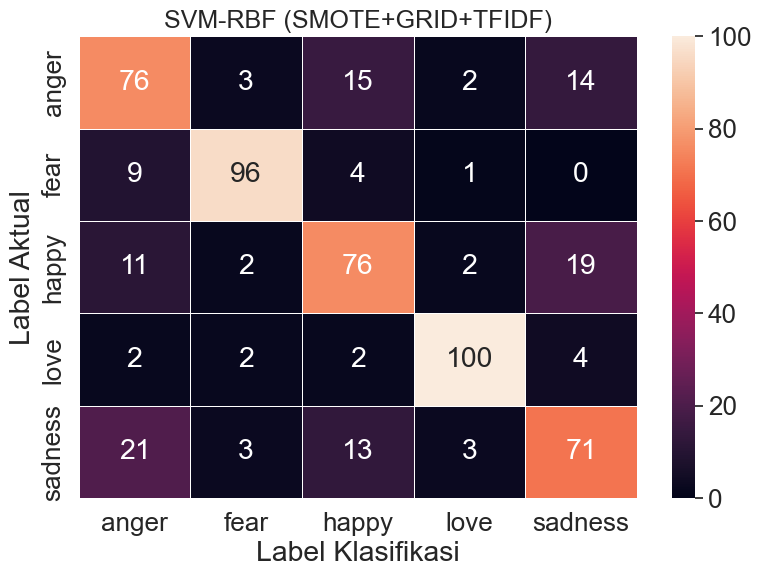

In [17]:
# menampilkan confusion matrix
temp = Y_test_tfidf.value_counts()
df1 = pd.DataFrame({'label': sorted(temp.index),
                   'values': temp.values
                  })
f, ax = plt.subplots(figsize=(9,6))
sns.set(font_scale=1.7) # Adjust to fit
sns.heatmap(confusion_matrix(Y_test_tfidf, predicted2), annot=True, fmt="g", ax=ax, linewidths=.5)
plt.title('SVM-RBF (SMOTE+GRID+TFIDF)', fontsize=18)
plt.xlabel("Label Klasifikasi")
plt.ylabel("Label Aktual")
ax.xaxis.set_ticklabels(df1['label'])
ax.yaxis.set_ticklabels(df1['label'])
plt.show()

## 3. KNN (SMOTE+GRID+BIGRAM) {n_neighbors = 1}

In [18]:
model3 = KNeighborsClassifier(n_neighbors = 1)

In [19]:
# Evaluasi training tiap skenario dengan 10-Fold CV
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
score3 = cross_validate(model3, X_train_bigram, Y_train_bigram, cv=10, scoring=scoring)
print("Accuracy training adalah %0.4f"% score3['test_accuracy'].mean())
print("Precision training adalah %0.4f"% score3['test_precision_macro'].mean())
print("Recall training adalah %0.4f"% score3['test_recall_macro'].mean())
print("F1-score training adalah %0.4f"% score3['test_f1_macro'].mean())

C:\Users\chavi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy training adalah 0.2774
Precision training adalah 0.6329
Recall training adalah 0.2773
F1-score training adalah 0.1996


C:\Users\chavi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# Evaluasi testing tiap skenario dengan representasi confusion matrix
clf3 = model3.fit(X_train_bigram, Y_train_bigram)
predicted3 = clf3.predict(X_test_bigram) # prediksi oleh model
print("Accuracy testing adalah %0.4f" % accuracy_score(Y_test_bigram, predicted3))
print("Precision testing adalah %0.4f" % precision_score(Y_test_bigram, predicted3, average='macro'))
print("Recall testing adalah %0.4f" % recall_score(Y_test_bigram, predicted3, average='macro'))
print("F1-score testing adalah %0.4f" % f1_score(Y_test_bigram, predicted3, average='macro'))
print(confusion_matrix(Y_test_bigram, predicted3))

Accuracy testing adalah 0.2722
Precision testing adalah 0.6656
Recall testing adalah 0.2726
F1-score testing adalah 0.1947
[[  2 100   0   8   0]
 [  0 107   0   3   0]
 [  0 101   9   0   0]
 [  0  80   1  27   2]
 [  0  96   1   9   5]]


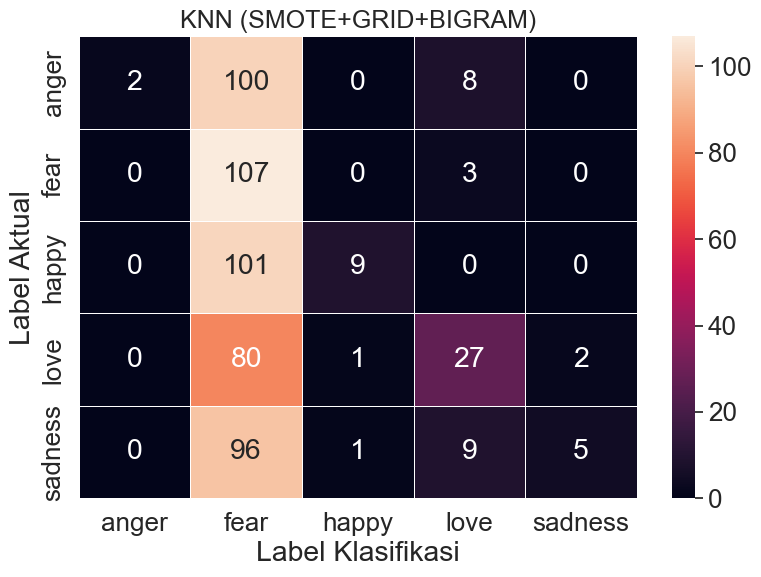

In [21]:
# menampilkan confusion matrix
temp = Y_test_bigram.value_counts()
df1 = pd.DataFrame({'label': sorted(temp.index),
                   'values': temp.values
                  })
f, ax = plt.subplots(figsize=(9,6))
sns.set(font_scale=1.7) # Adjust to fit
sns.heatmap(confusion_matrix(Y_test_bigram, predicted3), annot=True, fmt="g", ax=ax, linewidths=.5)
plt.title('KNN (SMOTE+GRID+BIGRAM)', fontsize=18)
plt.xlabel("Label Klasifikasi")
plt.ylabel("Label Aktual")
ax.xaxis.set_ticklabels(df1['label'])
ax.yaxis.set_ticklabels(df1['label'])
plt.show()

## 4. SVM-RBF (SMOTE+GRID+BIGRAM) {C = 10, gamma = 0.005}

In [22]:
model4 = SVC(kernel='rbf', probability=True, C = 10, gamma = 0.005)

In [23]:
# Evaluasi training tiap skenario dengan 10-Fold CV
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
score4 = cross_validate(model4, X_train_bigram, Y_train_bigram, cv=10, scoring=scoring)
print("Accuracy training adalah %0.4f"% score4['test_accuracy'].mean())
print("Precision training adalah %0.4f"% score4['test_precision_macro'].mean())
print("Recall training adalah %0.4f"% score4['test_recall_macro'].mean())
print("F1-score training adalah %0.4f"% score4['test_f1_macro'].mean())

Accuracy training adalah 0.3914
Precision training adalah 0.3939
Recall training adalah 0.3914
F1-score training adalah 0.3725


In [24]:
# Evaluasi testing tiap skenario dengan representasi confusion matrix
clf4 = model4.fit(X_train_bigram, Y_train_bigram)
predicted4 = clf4.predict(X_test_bigram) # prediksi oleh model
print("Accuracy testing adalah %0.4f" % accuracy_score(Y_test_bigram, predicted4))
print("Precision testing adalah %0.4f" % precision_score(Y_test_bigram, predicted4, average='macro'))
print("Recall testing adalah %0.4f" % recall_score(Y_test_bigram, predicted4, average='macro'))
print("F1-score testing adalah %0.4f" % f1_score(Y_test_bigram, predicted4, average='macro'))
print(confusion_matrix(Y_test_bigram, predicted4))

Accuracy testing adalah 0.4338
Precision testing adalah 0.4340
Recall testing adalah 0.4340
F1-score testing adalah 0.4216
[[65 19 11  5 10]
 [23 39  8 34  6]
 [24 14 34 24 14]
 [16  5 11 70  8]
 [31 14 17 18 31]]


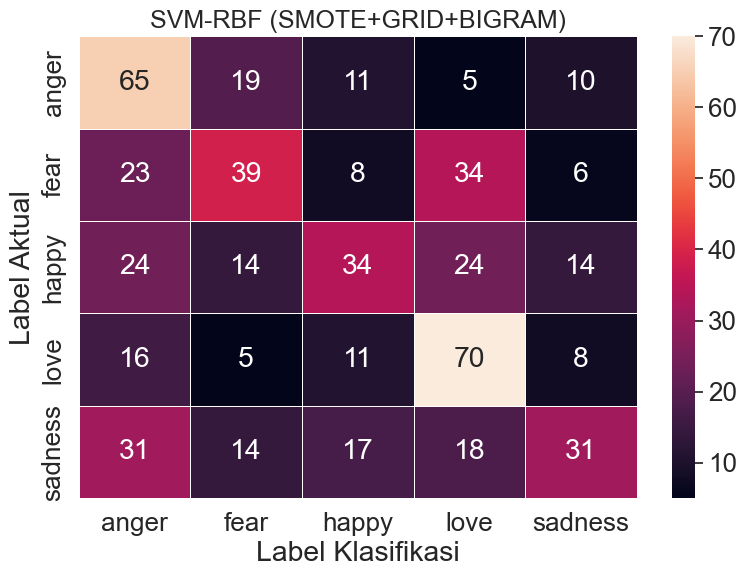

In [25]:
# menampilkan confusion matrix
temp = Y_test_bigram.value_counts()
df1 = pd.DataFrame({'label': sorted(temp.index),
                   'values': temp.values
                  })
f, ax = plt.subplots(figsize=(9,6))
sns.set(font_scale=1.7) # Adjust to fit
sns.heatmap(confusion_matrix(Y_test_bigram, predicted4), annot=True, fmt="g", ax=ax, linewidths=.5)
plt.title('SVM-RBF (SMOTE+GRID+BIGRAM)', fontsize=18)
plt.xlabel("Label Klasifikasi")
plt.ylabel("Label Aktual")
ax.xaxis.set_ticklabels(df1['label'])
ax.yaxis.set_ticklabels(df1['label'])
plt.show()

# DUMP VEKTORISASI DAN MODEL

## 1. SIMPAN HASIL VEKTORISASI KE BENTUK DISK (.PKL)

In [26]:
# simpan vektorisasi tfidf
#disk_tfidf = 'tf-idf.pkl'
#joblib.dump(tfidf, open(disk_tfidf, 'wb'))
# simpan vektorisasi bigram
#disk_bigram = 'bigram.pkl'
#joblib.dump(bigram, open(disk_bigram, 'wb'))

## 2. SIMPAN MODEL YANG SUDAH DILATIH KE BENTUK DISK (.PKL)

In [27]:
# simpan model KNN (SMOTE+GRID+TFIDF)
disk_model1 = 'knn-smote-grid-tfidf.pkl'
joblib.dump(model1, open(disk_model1, 'wb'))
# simpan model SVM-RBF (SMOTE+GRID+TFIDF)
disk_model2 = 'svm-smote-grid-tfidf.pkl'
joblib.dump(model2, open(disk_model2, 'wb'))
# simpan model KNN (SMOTE+GRID+BIGRAM)
disk_model3 = 'knn-smote-grid-bigram.pkl'
joblib.dump(model3, open(disk_model3, 'wb'))
# simpan model SVM-RBF (SMOTE+GRID+BIGRAM)
disk_model4 = 'svm-smote-grid-bigram.pkl'
joblib.dump(model4, open(disk_model4, 'wb'))